In [1]:
# NOTES
# TODO: Geo Data could use RAPIDS cuSpatial if necessary

# Setup

## Import Packages

In [2]:
# import packages
import os
import dotenv
from collections import Counter
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, LongType, DoubleType, TimestampType
import pyspark.sql.functions as F
from hdfs import InsecureClient

## Load Environemnt Variables

In [3]:
# load environment variables
dotenv.load_dotenv()

SPARK_CUDF_JAR = os.getenv('SPARK_CUDF_JAR')
SPARK_RAPIDS_PLUGIN_JAR = os.getenv('SPARK_RAPIDS_PLUGIN_JAR')
namenode_URI = os.getenv('namenode_URI')
hadoop_user = os.getenv('hadoop_user')
hdfs_path = os.getenv('hdfs_path')

## Configure Spark, Connection to HDFS

In [4]:
# configure environment & instantiate spark
# one cpu available, total 8 cores, 2 cores per executor
# one gpu available, 4 concurent tasks for gpu (1/4), 90% of gpu memory allowed for pooling by RAPIDS
# possibly implement SparkConf.set method to set config('spark.executor.resource.gpu.amount', '0.25')
spark = SparkSession.builder \
    .master('local') \
    .appName('nyc_taxi') \
    .config('spark.jars', f'{SPARK_CUDF_JAR},{SPARK_RAPIDS_PLUGIN_JAR}') \
    .config('spark.plugins', 'com.nvidia.spark.SQLPlugin') \
    .config('spark.executor.memory', '16g') \
    .config('spark.rapids.sql.enabled', 'true') \
    .config('spark.rapids.sql.incompatibleOps.enabled', 'true') \
    .config('spark.executor.cores', '2') \
    .config('spark.task.cpus', '1') \
    .config('spark.rapids.memory.gpu.pooling.enabled', 'true') \
    .config('spark.rapids.memory.gpu.allocFraction', '0.9') \
    .getOrCreate()


2021-10-26 17:42:02,398 WARN util.Utils: Your hostname, david-Z97X-Gaming-7 resolves to a loopback address: 127.0.1.1; using 192.168.0.159 instead (on interface enp42s0)
2021-10-26 17:42:02,399 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
2021-10-26 17:42:02,570 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2021-10-26 17:42:07,035 WARN rapids.SQLExecPlugin: RAPIDS Accelerator 21.08.0 using cudf 21.08.2. To disable GPU support set `spark.rapids.sql.enabled` to false
2021-10-26 17:42:07,036 WARN udf.Plugin: Installing rapids UDF compiler extensions to Spark. The compiler is disabled by default. To enable it, set `spark.rapids.sql.udfCompiler.enabled` to true


In [5]:
# list files in hdfs directory, count files in directory
hdfs = InsecureClient(namenode_URI, user=hadoop_user)
fs = hdfs.list(hdfs_path)
print(fs)
print('number of files in dfs directory:', len(fs))

['yellow_taxi_2017-01.parquet', 'yellow_taxi_2017-02.parquet', 'yellow_taxi_2017-03.parquet', 'yellow_taxi_2017-04.parquet', 'yellow_taxi_2017-05.parquet', 'yellow_taxi_2017-06.parquet', 'yellow_taxi_2017-07.parquet', 'yellow_taxi_2017-08.parquet', 'yellow_taxi_2017-09.parquet', 'yellow_taxi_2017-10.parquet', 'yellow_taxi_2017-11.parquet', 'yellow_taxi_2017-12.parquet', 'yellow_taxi_2018-01.parquet', 'yellow_taxi_2018-02.parquet', 'yellow_taxi_2018-03.parquet', 'yellow_taxi_2018-04.parquet', 'yellow_taxi_2018-05.parquet', 'yellow_taxi_2018-06.parquet', 'yellow_taxi_2018-07.parquet', 'yellow_taxi_2018-08.parquet', 'yellow_taxi_2018-09.parquet', 'yellow_taxi_2018-10.parquet', 'yellow_taxi_2018-11.parquet', 'yellow_taxi_2018-12.parquet', 'yellow_taxi_2019-01.parquet', 'yellow_taxi_2019-02.parquet', 'yellow_taxi_2019-03.parquet', 'yellow_taxi_2019-04.parquet', 'yellow_taxi_2019-05.parquet', 'yellow_taxi_2019-06.parquet', 'yellow_taxi_2019-07.parquet', 'yellow_taxi_2019-08.parquet', 'yellow

# Data Ingestion

In [6]:
# Get all column names in data
columns = []
for prqt in hdfs.list(hdfs_path):
    path = os.path.join('hdfs://localhost:9000/', hdfs_path, prqt)
    cols = spark.read \
        .options(header='true', inferschema='true') \
        .parquet(path) \
        .limit(1) \
        .columns
    
    columns.extend(cols)

# see what columns are similar between
counter = Counter(columns)
print(counter)

# lets take all columns that are present within all datasets (48 maximum columns count)
columns = [i[0] for i in counter.items() if i[1] == max([i[1]for i in counter.items()])]


Counter({'VendorID': 48, 'tpep_pickup_datetime': 48, 'tpep_dropoff_datetime': 48, 'passenger_count': 48, 'trip_distance': 48, 'RatecodeID': 48, 'store_and_fwd_flag': 48, 'PULocationID': 48, 'DOLocationID': 48, 'payment_type': 48, 'fare_amount': 48, 'extra': 48, 'mta_tax': 48, 'tip_amount': 48, 'tolls_amount': 48, 'improvement_surcharge': 48, 'total_amount': 48, 'congestion_surcharge': 24})


In [7]:
# set the schema for data
customSchema = StructType([
    StructField('VendorID', LongType(), True),
    StructField('tpep_pickup_datetime', TimestampType(), True),
    StructField('tpep_dropoff_datetime', TimestampType(), True),
    StructField('passenger_count', LongType(), True),
    StructField('trip_distance', DoubleType(), True),
    StructField('RatecodeID', LongType(), True),
    StructField('store_and_fwd_flag', StringType(), True),
    StructField('PULocationID', LongType(), True),
    StructField('DOLocationID', LongType(), True),
    StructField('payment_type', LongType(), True),
    StructField('fare_amount', DoubleType(), True),
    StructField('extra', DoubleType(), True),
    StructField('mta_tax', DoubleType(), True),
    StructField('tip_amount', DoubleType(), True),
    StructField('tolls_amount', DoubleType(), True),
    StructField('improvement_surcharge', DoubleType(), True),
    StructField('total_amount', DoubleType(), True)
])


In [8]:
# read in data
path = os.path.join('hdfs://localhost:9000/', hdfs_path, '*')
df = spark.read \
    .format('parquet') \
    .schema(customSchema) \
    .load(path)


In [9]:
# check final schema
df.printSchema()


root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [10]:
# preview of concatenated dataframe size
print('number of rows: ', round(df.count() / 1e6, 2), 'Million',
      '\nnumber of columns: ', len(df.columns),
      '\ntotal count of data: ', round(df.count() * len(df.columns) / 1e9, 2), 'Billion')


number of rows:  325.35 Million 
number of columns:  17 
total count of data:  5.53 Billion


In [11]:
# load location lookup table
lookup_table = pd.read_csv('./data/taxi_location_lookup_table.csv')

# load geographic data (shapefile)
gfp = './data/geo_files/taxi_zones.shp'
gdf = gpd.read_file(gfp)

# Data Preparation

## Spark

In [12]:
# check for null values in dataframe
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]) \
    .toPandas() \
    .transpose() \
    .rename(columns={0: 'count_na'})

# seems like there are issues with about 1M rows of the data missing VendorID, passenger_count, RatecodeID, payment_type
# remaining columns have no null values

,count_na
VendorID,1056169
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,1056169
trip_distance,0
RatecodeID,1056169
store_and_fwd_flag,0
PULocationID,0
DOLocationID,0
payment_type,1056169


In [13]:
# check the dates of null value rows
print('dates with null values')
df.filter(F.col('VendorID').isNull()) \
    .groupBy(F.year('tpep_pickup_datetime'), F.month('tpep_pickup_datetime')) \
    .count().alias('count_na') \
    .toPandas().sort_values(by=['year(tpep_pickup_datetime)', 'month(tpep_pickup_datetime)'])

dates with null values


,year(tpep_pickup_datetime),month(tpep_pickup_datetime),count
6,2019,6,161
16,2019,7,33970
5,2019,8,33235
11,2019,9,34197
0,2019,10,46826
17,2019,11,47311
12,2019,12,51198
9,2020,1,65347
14,2020,2,48760
3,2020,3,37474


In [14]:
# remove rows with null values
df = df.filter(~F.col('VendorID').isNull()).collect()

In [15]:
# we should only have data on years 2017 - 2020
print('unique years:', df.select(F.year(df.tpep_pickup_datetime)).distinct().collect())

# check how many rows of data are not within 2017-2020
years = ['2017', '2018', '2019', '2020']
print('rows with wrong years:', df.filter(~F.year(df.tpep_pickup_datetime).isin(years)).count())

# 113.5k relatively small amount of taxi rides compared to 325.3m, we can drop these rows
df = df.filter(F.year(df.tpep_pickup_datetime).isin(years))

unique years: [Row(year(tpep_pickup_datetime)=2003), Row(year(tpep_pickup_datetime)=2018), Row(year(tpep_pickup_datetime)=2015), Row(year(tpep_pickup_datetime)=2032), Row(year(tpep_pickup_datetime)=2090), Row(year(tpep_pickup_datetime)=2031), Row(year(tpep_pickup_datetime)=2042), Row(year(tpep_pickup_datetime)=2038), Row(year(tpep_pickup_datetime)=2037), Row(year(tpep_pickup_datetime)=2026), Row(year(tpep_pickup_datetime)=2041), Row(year(tpep_pickup_datetime)=2019), Row(year(tpep_pickup_datetime)=2029), Row(year(tpep_pickup_datetime)=2053), Row(year(tpep_pickup_datetime)=2020), Row(year(tpep_pickup_datetime)=2033), Row(year(tpep_pickup_datetime)=2009), Row(year(tpep_pickup_datetime)=2016), Row(year(tpep_pickup_datetime)=2088), Row(year(tpep_pickup_datetime)=2058), Row(year(tpep_pickup_datetime)=2001), Row(year(tpep_pickup_datetime)=2084), Row(year(tpep_pickup_datetime)=2000), Row(year(tpep_pickup_datetime)=2010), Row(year(tpep_pickup_datetime)=2008), Row(year(tpep_pickup_datetime)=2017

rows with wrong years: 113510


In [16]:
# check the months within the data
df.select(F.month(df.tpep_pickup_datetime)).distinct().collect()
# time 1m 30.6s

[Row(month(tpep_pickup_datetime)=12),
 Row(month(tpep_pickup_datetime)=1),
 Row(month(tpep_pickup_datetime)=6),
 Row(month(tpep_pickup_datetime)=3),
 Row(month(tpep_pickup_datetime)=5),
 Row(month(tpep_pickup_datetime)=9),
 Row(month(tpep_pickup_datetime)=4),
 Row(month(tpep_pickup_datetime)=8),
 Row(month(tpep_pickup_datetime)=7),
 Row(month(tpep_pickup_datetime)=10),
 Row(month(tpep_pickup_datetime)=11),
 Row(month(tpep_pickup_datetime)=2)]

In [17]:
# check if the years are correct like the pickup datetime
print('unique years:', df.select(F.year(df.tpep_dropoff_datetime)).distinct().collect())

# there are extra rows with improper years, check the amount of bad data
print('rows with wrong years:', df.filter(~F.year(df.tpep_dropoff_datetime).isin(years)).count())

# only 75 rows, we can drop them
df = df.filter(F.year(df.tpep_dropoff_datetime).isin(years))

unique years: [Row(year(tpep_dropoff_datetime)=2018), Row(year(tpep_dropoff_datetime)=1997), Row(year(tpep_dropoff_datetime)=2019), Row(year(tpep_dropoff_datetime)=1998), Row(year(tpep_dropoff_datetime)=2020), Row(year(tpep_dropoff_datetime)=1926), Row(year(tpep_dropoff_datetime)=2016), Row(year(tpep_dropoff_datetime)=2017), Row(year(tpep_dropoff_datetime)=2021)]


rows with wrong years: 75


In [18]:
# check the months within the dates
df.select(F.month(df.tpep_dropoff_datetime)).distinct().collect()

[Row(month(tpep_dropoff_datetime)=12),
 Row(month(tpep_dropoff_datetime)=1),
 Row(month(tpep_dropoff_datetime)=6),
 Row(month(tpep_dropoff_datetime)=3),
 Row(month(tpep_dropoff_datetime)=5),
 Row(month(tpep_dropoff_datetime)=9),
 Row(month(tpep_dropoff_datetime)=4),
 Row(month(tpep_dropoff_datetime)=8),
 Row(month(tpep_dropoff_datetime)=7),
 Row(month(tpep_dropoff_datetime)=10),
 Row(month(tpep_dropoff_datetime)=11),
 Row(month(tpep_dropoff_datetime)=2)]

In [19]:
# user defined function for finding difference between two timestamps in minutes
time_difference_udf = F.udf(lambda pickup, dropoff: (F.unix_timestamp(dropoff) - F.unix_timestamp(pickup)) / 60, DoubleType())

In [20]:
# get attributes of dates
df = df.withColumn('pickup_year', F.year('tpep_pickup_datetime')) \
       .withColumn('pickup_month', F.month('tpep_pickup_datetime')) \
       .withColumn('pickup_week', F.weekofyear('tpep_pickup_datetime')) \
       .withColumn('ride_duration', time_difference_udf(F.col('tpep_pickup_datetime'), F.col('tpep_dropoff_datetime')))

In [21]:
# sum of fares and count of rides by year, month
fare_by_year_month = df.groupBy('pickup_year', 'pickup_month') \
                        .agg(F.sum('fare_amount').alias('total_fares'), F.count('*').alias('num_rides')) \
                        .toPandas()

fare_by_year_month.head()

,pickup_year,pickup_month,total_fares,num_rides
0,2019,10,9.712624e+07,7195297
1,2017,3,1.331977e+08,10309482
2,2017,8,1.110681e+08,8433694
3,2020,6,5.918389e+06,499575
4,2019,5,1.019473e+08,7584383


In [22]:
# get total fares and count of rides by pick up and drop off location pairs
fares_by_locations = df.groupBy('PULocationID', 'DOLocationID') \
                        .agg(F.sum('fare_amount').alias('total_fare'),
                             F.count('fare_amount').alias('num_rides')) \
                        .toPandas()

fares_by_locations.head()

,PULocationID,DOLocationID,total_fare,num_rides
0,137,37,103653.43,4192
1,142,144,480082.34,22880
2,90,231,1525380.04,149342
3,255,262,18637.50,764
4,234,144,1657751.88,173250


## Joining Geographic Data

(263, 7)


<AxesSubplot:>

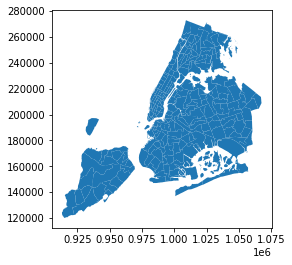

In [23]:
print(gdf.shape)
gdf.plot()

# APPENDIX

```python
# RDD implementation of fares_by_locations (GPU not utilized)
fares_by_locations = df.select(['PULocationID', 'DOLocationID', 'fare_amount']).rdd \
                         .map(lambda x: ((x[0], x[1]), x[2])) \
                         .reduceByKey(lambda x, y: x + y) \
                         .toDF().toPandas()
time: 10m 53s
```